In [20]:
import os.path
import time

import torch
torch.cuda.empty_cache()

# Imports


In [21]:
from src.efficentnet_train import data_load,models_train,visualization,utils,generate_dataset,evaluation
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from src.efficentfacenet import face_descriptor
from torchvision import transforms
import pandas as pd
import time
import os
import torch
def get_last_weights_path(weights_path):
    files=os.listdir(weights_path)
    files.sort()
    last_weight_file_name=files[-1]
    return f"{weights_path}/{last_weight_file_name}"

In [22]:
dataset_path = "../dataset/preprocessed/img_celeb_full"
model_weights_path="../model_weights/convnext_tiny"
train_data_save_path="../training log/convnext"
lfw_dataset_path="../dataset/preprocessed/lfw_prep"
img_celeb_subset="../dataset/preprocessed/img_celeb_test"
batch_size=6
stop_n_layers=5

In [2]:
train_history=pd.read_csv(train_data_save_path+"/train_data.csv",index_col=False)

NameError: name 'pd' is not defined

In [4]:
train_history

,Train Loss,no train rows,Test Loss,No test rows,Time taken (M),Notes,Date,Time
0,0.280173,100000,0.342320,25000,65.2,remove sigmoid from classifier + input normali...,15/05/2022,23:26:00
1,0.989897,100000,1.000320,25000,60.1,remove sigmoid from classifier + input normali...,16/05/2022,0:27:00
2,1.000000,100000,1.000320,25000,60.2,remove sigmoid from classifier + input normali...,16/05/2022,1:27:00
3,0.173325,50000,0.284327,10000,63.0,remove sigmoid from classifier + input normali...,16/05/2022,19:28:00
4,0.243919,50000,0.281481,10000,60.0,remove sigmoid from classifier + input normali...,16/05/2022,20:28:00
...,...,...,...,...,...,...,...,...
141,0.099156,10000,0.173237,2500,18.4,"Classifier -->(1280,256,128)+ full train , ran...",21/05/2022,11:59:00
142,0.098474,10000,0.151633,2500,19.1,"Classifier -->(1280,256,128)+ full train , ran...",21/05/2022,12:19:00
143,0.093220,10000,0.161684,2500,20.1,"Classifier -->(1280,256,128)+ full train , ran...",21/05/2022,12:39:00
144,0.099141,10000,0.121382,2500,20.0,"Classifier -->(1280,256,128)+ full train , ran...",21/05/2022,12:59:00


# Load Data

In [61]:
train_transform = transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),data_load.Normalize()])
test_transform=transforms.Compose([transforms.ToTensor(),data_load.Normalize()])

# Face descriptor model train

In [4]:
train_data_features=utils.load_dict_from_json("train_face_features_0.018.json")

In [50]:
train_dataset = data_load.FacesTripletDataset(f"{dataset_path}/train", 5000, train_transform,load_imgs_from_dict=False)
test_dataset=data_load.FacesTripletDataset(f"{dataset_path}/test", 2500, test_transform,False)


In [51]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [52]:

face_descriptor_model=face_descriptor.FaceDescriptorModel()
face_descriptor_model.load_local_weights(utils.get_last_weights_path(model_weights_path))

0.15358901023864746


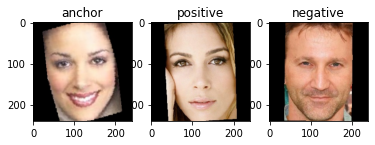

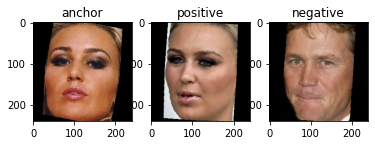

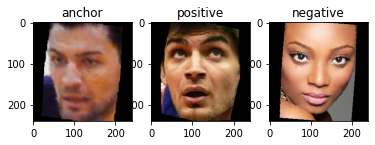

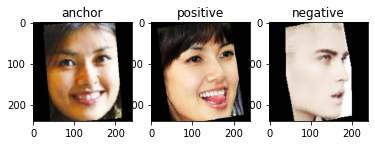

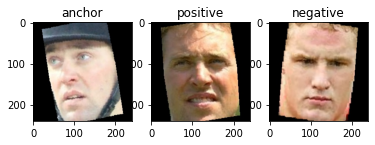

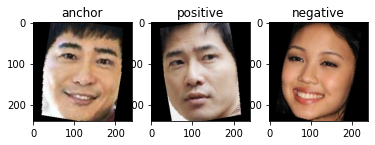

In [53]:
ts=time.time()
a_batch, p_batch, n_batch = next(iter(train_loader))
print(time.time()-ts)
for i in range(batch_size):
    fig, ax = plt.subplots(1, 3)
    ax[0].set_title("anchor")
    ax[0].imshow(a_batch[i].numpy().transpose([1,2,0]))


    ax[1].set_title("positive")
    ax[1].imshow(p_batch[i].numpy().transpose([1,2,0]))



    ax[2].set_title("negative")
    ax[2].imshow(n_batch[i].numpy().transpose([1,2,0]))



Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1000, bias=True)
)

In [10]:
# model.load_local_weights("../model_weights/training/05_25 22_43 Train_(0.019421) Test_(0.015686).pt",True)
# model.load_local_weights("../model_weights/training/05_26 08_09 Train_(0.026858) Test_(0.019528).pt",True)
face_descriptor_model.load_local_weights("../model_weights/training/05_28 06_31 Train_(0.042632) Test_(0.015599).pt",True)
# model.load_local_weights("../model_weights/training/06_03 15_01 Train_(0.126938) Test_(0.167481).pt",True)


In [13]:
for i in range (len(face_descriptor_model.features)):
      for parm in face_descriptor_model.features[i].parameters():
            parm.requires_grad=True

In [22]:
for i in range(stop_n_layers):
  for parm in face_descriptor_model.features[i].parameters():
    parm.requires_grad=False


In [10]:
for parm in face_descriptor_model.parameters():
    parm.requires_grad=True

In [11]:
epochs=15
learning_rate=0.01
train_notes="descriptor with  standardization classifier (768,128)"


In [ ]:
# train_data_features=data_load.get_pic_features_dict(dataset_path+"/train",model=model,transform=test_transform,cuda=True)

 data processed [..........] time remaing=250.1

In [14]:
utils.save_dict_to_json("train_face_features_0.018.json",train_data_features)

In [ ]:
ef

In [54]:
train_losses=models_train.model_train(face_descriptor_model,epochs=15,learn_rate=0.00001,train_loader=train_loader,test_loader=test_loader,train_mod="triplet",cuda=True,weight_saving_path=model_weights_path,epoch_data_saving_path=train_data_save_path,notes=train_notes)

Testing before training ...
 Testing  [==========] time taken (m) = 1.850104 Avg Test_Loss=0.0780737352Test Loss before Training=0.07813592641521246
-----------------------------------------------------
 epoch 1 [==========] time Taken (git m) = 19.40845 Avg Train_Loss=0.065732
mean of unique pictures usage count = 1.082 and std = 0.095 , no of unique pictures used =13876
 Testing  [==========] time taken (m) = 1.864934 Avg Test_Loss=0.0708170005 epoch 1 train_loss =0.0657855523467064 test_loss=0.07087375121377408
new minimum test loss 0.070873  achieved, model weights saved 
!!!Warning Overfitting!!!
-----------------------------------------------------
 epoch 2 [===.......] time remaining (m) = 11.92169 Avg Train_Loss=0.051451

KeyboardInterrupt: 

In [21]:
face_descriptor_model.load_local_weights(model_weights_path+"/05_25 22_43 Train_(0.019421) Test_(0.015686).pt",cuda_weights=True)

## Descriptor Hard anchor negative selection

In [62]:

face_descriptor_model=face_descriptor.FaceDescriptorModel()
face_descriptor_model.load_local_weights(utils.get_last_weights_path(model_weights_path))


In [63]:
img_features=None
stop_n_layers=5

In [64]:
import torch.nn as nn
models_train.model_test(model=face_descriptor_model,test_loader=test_loader,loss_function=nn.TripletMarginLoss(),test_mod="triplet",cuda=True)

 Testing  [..........] time remaining (m) = 1.820943 Avg Test_Loss=0.053199

KeyboardInterrupt: 

In [65]:
for i in range(stop_n_layers):
    for param in face_descriptor_model.features[i].parameters():
        param.requires_grad=False

In [66]:
import torch
epochs=25
learning_rate=0.00001
train_notes="descriptor hard negative selection from 10 not 5 , starting with test 0.2 loss calculation fixed"


In [67]:
optimizer=torch.optim.Adam(params=face_descriptor_model.parameters(),lr=learning_rate)


In [68]:
# img_features=data_load.get_pic_features_dict(dataset_path+"/train",model=model,transform=test_transform,cuda=True,batch_size=10)
# img_features=utils.load_dict_from_json("train_face_features_0.13.json")
img_features=None

In [69]:
state_dict=torch.load(model_weights_path+"06_05 12_32 Train_(0.194497) Test_(0.073888).pt")
face_descriptor_model.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: '../model_weights/convnext_tiny06_05 12_32 Train_(0.194497) Test_(0.073888).pt'

In [70]:
train_dataset = data_load.FacesHardTripletDataset(face_descriptor_model,True,f"{dataset_path}/train", 10000, train_transform,load_imgs_from_dict=False,img_features_dict=img_features,select_from_negative_cnt=10)
test_dataset=data_load.FacesTripletDataset(f"{dataset_path}/test", 5000, test_transform,False)

 data processed [==========] time remaing=-0.00


In [100]:
train_dataset.select_from_negative_cnt=10

In [71]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [72]:
train_losses=models_train.model_train(face_descriptor_model,epochs=epochs,learn_rate=learning_rate,train_loader=train_loader,test_loader=test_loader,train_mod="triplet",cuda=True,weight_saving_path=model_weights_path,epoch_data_saving_path=train_data_save_path,notes=train_notes,optimizer=optimizer)

Testing before training ...
 Testing  [==========] time taken (m) = 3.756256 Avg Test_Loss=0.0557195786Test Loss before Training=0.05576447106900159
-----------------------------------------------------

 epoch 1 [==========] time Taken (git m) = 22.31991 Avg Train_Loss=0.245007
mean of unique pictures usage count = 1.104 and std = 0.126 , no of unique pictures used =27182
 Testing  [==========] time taken (m) = 3.673002 Avg Test_Loss=0.0616101684 epoch 1 train_loss =0.24505671080562752 test_loss=0.061659410783147905
-----------------------------------------------------
 data processed [==========] time remaing=-0.00
 epoch 2 [==========] time Taken (git m) = 22.02035 Avg Train_Loss=0.222946
mean of unique pictures usage count = 1.238 and std = 0.324 , no of unique pictures used =48463
 Testing  [==========] time taken (m) = 3.645274 Avg Test_Loss=0.0528122876 epoch 2 train_loss =0.22299112134889293 test_loss=0.05285494409550447
new minimum test loss 0.052854  achieved, model weights s

KeyboardInterrupt: 

In [26]:
models_train.save_train_weights(face_descriptor_model,0.25539063,0.06614,model_weights_path)

'../model_weights/convnext_tiny/06_06 04_02 Train_(0.255390) Test_(0.06614).pt'

In [14]:
utils.save_dict_to_json("train_face_features_0.13.json",train_dataset.img_features_dict)

# Face descriptor evaluation

In [34]:
state_dict=torch.load(model_weights_path+"/06_06 12_02 Train_(0.239315) Test_(0.055797).pt")
face_descriptor_model.load_state_dict(state_dict)

<All keys matched successfully>

In [38]:
eval_transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((240,240)),data_load.Normalize()])

In [39]:
features_dict=data_load.get_pic_features_dict(lfw_dataset_path,face_descriptor_model,eval_transform,cuda=True,batch_size=10)

 data processed [==========] time remaing=-0.00


In [21]:
# features_dict=train_dataset.img_features_dict

In [19]:
utils.save_dict_to_json("face_features.json",img_features)

In [77]:
features_dict=imgs_features_dict=utils.load_dict_from_json("face_features.json")


KeyboardInterrupt: 

In [40]:
test_data_pd_full=pd.DataFrame(generate_dataset.generate_testing_data_set_frame(lfw_dataset_path,True))

In [41]:
full_test_data_pd = test_data_pd_full.sample(frac=1)
test_data_pd = full_test_data_pd[:100000]

In [47]:
evaluation.model_test(features_dict, test_data_pd, results_path="", threshold=7.2)

 Testing  [==========] time remaining = 0.0 Accuracy =94.951Accuracy now equal --> 94.9510%


(                              Mertic          Value
 0                     processed rows  100000.000000
 1  Model accuracy on Proceed Faces %      94.951000
 2                     False Positive    2536.000000
 3                     False Negative    2513.000000
 4                          precision       0.949235
 5                             recall       0.949672
 6                        fbeta-score       0.515243
 7           avg same person distance       5.608793
 8           avg diff person distance       9.885721
 9                    Model tolerance       7.200000,
                  Actual True  Actual False
 Predicted True         47438          2536
 Predicted False         2513         47513)

In [98]:
evaluation.model_test(features_dict,test_data_pd,results_path="",threshold=7.55)

 Testing  [==========] time remaining = 0.0 Accuracy =91.034Accuracy now equal --> 91.0336%


(                              Mertic          Value
 0                     processed rows  399058.000000
 1  Model accuracy on Proceed Faces %      91.034000
 2                     False Positive   17630.000000
 3                     False Negative   18151.000000
 4                          precision       0.911406
 5                             recall       0.909026
 6                        fbeta-score       0.484639
 7           avg same person distance       5.829306
 8           avg diff person distance      10.100322
 9                    Model tolerance       7.550000,
                  Actual True  Actual False
 Predicted True        181378         17630
 Predicted False        18151        181899)

## test from outside data

# Efficient-Facenet model train
- the trained descriptor + classifier

In [4]:
# descriptor_weights="../model_weights/training/05_26 18_02 Train_(0.022302) Test_(0.018650).pt"
descriptor_weights="../model_weights/convnext_tiny/06_06 15_46 Train_(0.230367) Test_(0.054825).pt"
effnet_weights_path="../model_weights/efficient_facenet"

In [5]:
pair_train_dataset=data_load.FacesPairDataset(f"{dataset_path}/train",5000,train_transform)
pair_test_dataset=data_load.FacesPairDataset(f"{dataset_path}/test",1000,test_transform)

In [14]:
pair_train_loader=DataLoader(pair_train_dataset,64,shuffle=False)
pair_test_loader=DataLoader(pair_test_dataset,64,shuffle=False)

In [7]:

x=next(iter(pair_test_loader))
len(x)


3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0.17951726913452148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


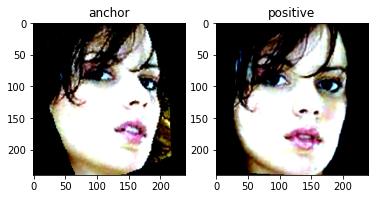

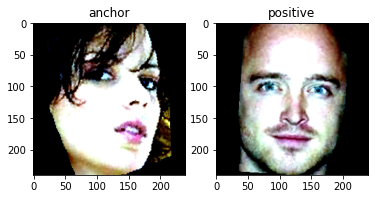

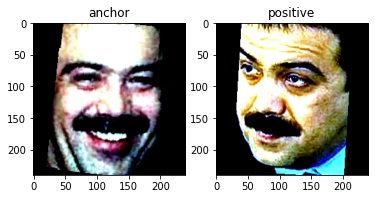

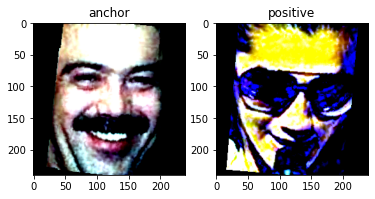

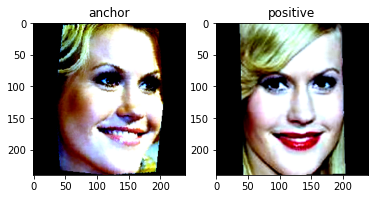

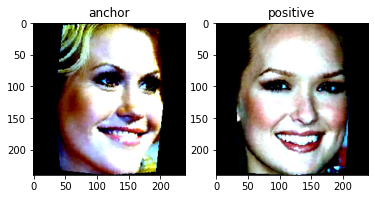

In [11]:
ts=time.time()
a_batch, p_batch ,labels= next(iter(pair_train_loader))
print(time.time()-ts)
for i in range(batch_size):
    fig, ax = plt.subplots(1, 2)
    ax[0].set_title("anchor")
    ax[0].imshow(a_batch[i].numpy().transpose([1,2,0]))


    ax[1].set_title("positive")
    ax[1].imshow(p_batch[i].numpy().transpose([1,2,0]))




In [8]:
efficient_facenet=face_descriptor.EfficientFacenet(128,descriptor_weights)


In [9]:
efficient_facenet.classifier

Sequential(
  (0): Linear(in_features=256, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=128, out_features=1, bias=True)
  (4): Sigmoid()
)

In [32]:
for i in range(4):
    for param in efficient_facenet.descriptor.features[i]:
        param.requires_grad=False

In [53]:
for param in efficient_facenet.parameters():
    param.requires_grad=True

In [10]:
for param in efficient_facenet.descriptor.parameters():
    param.requires_grad=False

In [11]:
train_notes=" facenet classifier with convnext backens descriptor full model"
model_weights_path="../model_weights/efficient_facenet"

In [16]:
efficient_facenet.descriptor.load_local_weights("../model_weights/convnext_tiny/06_06 12_02 Train_(0.239315) Test_(0.055797).pt")

In [108]:
efficient_facenet.descriptor.load_local_weights(descriptor_weights)

In [17]:
from torch.optim import Adam
optimizer = Adam(efficient_facenet.parameters(), lr=0.0001)

In [18]:
models_train.model_train(efficient_facenet,100,0.00001,pair_train_loader,pair_test_loader,"pair",cuda=True,weight_saving_path=model_weights_path,epoch_data_saving_path=train_data_save_path,notes=train_notes,optimizer=optimizer)

Testing before training ...
 Testing  [==========] time taken (m) = 0.452108 Avg Test_Loss=0.2859647247Test Loss before Training=0.29282804203033447
-----------------------------------------------------
 epoch 1 [==========] time Taken (git m) = 2.277867 Avg Train_Loss=0.300274
mean of unique pictures usage count = 1.344 and std = 0.572 , no of unique pictures used =51263
 Testing  [==========] time taken (m) = 0.448703 Avg Test_Loss=0.2666433776 epoch 1 train_loss =0.30363777084350585 test_loss=0.2730433549880981
new minimum test loss 0.273043  achieved, model weights saved 
-----------------------------------------------------
 epoch 2 [==========] time Taken (git m) = 2.278389 Avg Train_Loss=0.299922
mean of unique pictures usage count = 1.379 and std = 0.654 , no of unique pictures used =55399
 Testing  [==========] time taken (m) = 0.449467 Avg Test_Loss=0.2667249336 epoch 2 train_loss =0.303282120513916 test_loss=0.273125527381897
-------------------------------------------------

KeyboardInterrupt: 

In [13]:
efficient_facenet.load_local_weights(get_last_weights_path(effnet_weights_path),True)

In [15]:
celeb_subset_data_path="../dataset/preprocessed/img_celeb_test"
imgs_features_dict=data_load.get_pic_features_dict(celeb_subset_data_path,model=efficient_facenet.descriptor,transform=test_transform,cuda=True,batch_size=10)

 data processed [==========] time remaing=-0.00

In [48]:

imgs_features_dict=utils.load_dict_from_json("face_features.json")

In [111]:
imgs_features_dict=features_dict

In [15]:
utils.save_dict_to_json("lfw_face_features.json",imgs_features_dict)


In [11]:
imgs_features_dict=utils.load_dict_from_json("face_features.json")

In [16]:
full_test_data_pd=pd.DataFrame(generate_dataset.generate_testing_data_set_frame(img_celeb_subset,False))

In [ ]:
efficient_facenet.cuda()

In [32]:
full_test_data_pd=full_test_data_pd.sample(frac=1)
test_data_pd=full_test_data_pd[:9000]

In [33]:
error_table, confusion_table=evaluation.model_test(imgs_features_dict,test_data_pd,results_path="",threshold=0.7,classifier=efficient_facenet.classify_face_features,cuda=True)

 Testing  [==========] time remaining = 0.0 Accuracy =84.533Accuracy now equal --> 84.5333%


In [31]:
error_table

,Mertic,Value
0,processed rows,1000.0
1,Model accuracy on Proceed Faces %,83.2
2,False Positive,84
3,False Negative,84
4,precision,0.830339
5,recall,0.830339
6,fbeta-score,0.422896
7,avg same person distance,[0.76855516]
8,avg diff person distance,[0.2861738]
9,Model tolerance,0.7


In [75]:
error_table

,Mertic,Value
0,processed rows,10000.0
1,Model accuracy on Proceed Faces %,85.29
2,False Positive,765
3,False Negative,706
4,precision,0.850186
5,recall,0.860111
6,fbeta-score,0.441012
7,avg same person distance,[0.77617145]
8,avg diff person distance,[0.28642783]
9,Model tolerance,0.65


In [68]:
error_table

,Mertic,Value
0,processed rows,10000.0
1,Model accuracy on Proceed Faces %,85.59
2,False Positive,923
3,False Negative,518
4,precision,0.829079
5,recall,0.896221
6,fbeta-score,0.44155
7,avg same person distance,[0.7575226]
8,avg diff person distance,[0.28016078]
9,Model tolerance,0.57


In [85]:
error_table

,Mertic,Value
0,processed rows,10000.0
1,Model accuracy on Proceed Faces %,86.31
2,False Positive,848
3,False Negative,521
4,precision,0.840653
5,recall,0.895621
6,fbeta-score,0.446928
7,avg same person distance,[0.76668626]
8,avg diff person distance,[0.22067705]
9,Model tolerance,0.56


In [86]:
confusion_table

,Actual True,Actual False
Predicted True,4479,848
Predicted False,521,4152


In [14]:
import torch
x=torch.tensor([1,2])
y=[1,2]

In [16]:
print(isinstance(y,torch.Tensor))

False


In [17]:
x.numpy()

array([1, 2], dtype=int64)

In [34]:
test_data_pd.head()

,0,1,2
0,9236/042921.jpg,9236/052346.jpg,1
1,9236/042921.jpg,8647/101929.jpg,0
2,9236/042921.jpg,9236/071430.jpg,1
3,9236/042921.jpg,281/129193.jpg,0
4,9236/042921.jpg,9236/082375.jpg,1


In [72]:
efficient_facenet.cpu()

EfficientFacenet(
  (descriptor): FaceDescriptorModel(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
           

In [79]:
s=77
e=100

In [80]:
for idx in range(s,e):
    face_x_path,face_y_path=f"{dataset_path}/test/{test_data_pd.iloc[idx][0]}",f"{dataset_path}/test/{test_data_pd.iloc[idx][1]}"
    label=test_data_pd.iloc[idx][2]

    face_x_img,face_y_img=data_load.load_image(face_x_path,test_transform,True),data_load.load_image(face_y_path,test_transform,True)
    pred=efficient_facenet.identify_faces(face_x_img,face_y_img)

    print(f"predicted Value={pred} actual={label}")

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

tensor([[0.8023]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.08477306365966797
predicted Value=tensor([0.9411]) actual=tensor([1.])


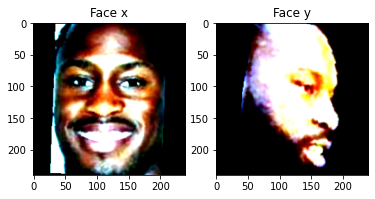

In [73]:
import time
ts=time.time()
face_x_img, face_y_img, label = next(iter(pair_test_loader))
print(time.time()-ts)
i=6
fig, ax = plt.subplots(1, 2)
ax[0].set_title("Face x")
ax[0].imshow(face_x_img[i].numpy().transpose([1,2,0]))


ax[1].set_title("Face y")
ax[1].imshow(face_y_img[i].numpy().transpose([1,2,0]))

pred=efficient_facenet.identify_faces(face_x_img,face_y_img)
print(f"predicted Value={pred[i]} actual={label[i]}")




## EfficentNet Hard anchor negative selection

In [4]:
train_notes="efficient facenet classifier on full img_net photos , hard negative selection"
model_weights_path="../model_weights/efficient_facenet"

In [5]:
pair_train_dataset=data_load.FacesPairDataset(f"{dataset_path}/train",5000,train_transform)
pair_test_dataset=data_load.FacesPairDataset(f"{dataset_path}/test",1000,test_transform)

In [6]:
pair_train_loader=DataLoader(pair_train_dataset,12,shuffle=False)
pair_test_loader=DataLoader(pair_test_dataset,12,shuffle=False)

In [31]:
efficient_facenet=face_descriptor.EfficientFacenet(128)
efficient_facenet.load_local_weights(get_last_weights_path(model_weights_path), cuda_weights=True)
for i in range(0):
    for param in efficient_facenet.descriptor.features[i]:
        param.requires_grad=False

In [35]:

train_losses = models_train.model_train(efficient_facenet, epochs=1, learn_rate=0.001,
                                            train_loader=pair_train_loader, test_loader=pair_test_loader, train_mod="pair",
                                            cuda=True, weight_saving_path=model_weights_path,
                                            epoch_data_saving_path=train_data_save_path, notes=train_notes,
                                            )


Testing before training ...
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.029022Test Loss before Training=0.029255083046853543
 epoch 1 [=======...] time remaining = 1.284648 Avg Train_Loss=0.051285

KeyboardInterrupt: 

In [ ]:

efficient_facenet=face_descriptor.EfficientFacenet(128)
efficient_facenet.load_local_weights(get_last_weights_path(model_weights_path), cuda_weights=True)
img_features = None
import torch
update_features_every_epochs = 10
epochs = 50
learning_rate = 0.0001
optimizer = torch.optim.Adam(params=efficient_facenet.parameters(), lr=learning_rate)

for i in range(int(epochs / update_features_every_epochs)):
    if img_features is None:
        img_features = data_load.get_pic_features_dict(dataset_path + "/train", model=efficient_facenet.descriptor, transform=test_transform,cuda=True,batch_size=10)
    pair_train_dataset=data_load.FacesPairDataset(f"{dataset_path}/train",5000,train_transform,load_imgs_from_dict=False, img_features_dict=img_features,
                                                  select_from_negative_cnt=5)
    pair_test_dataset=data_load.FacesPairDataset(f"{dataset_path}/test",1000,test_transform)


    pair_train_loader=DataLoader(pair_train_dataset,12,shuffle=False)
    pair_test_loader=DataLoader(pair_test_dataset,12,shuffle=False)

    train_losses = models_train.model_train(efficient_facenet, epochs=update_features_every_epochs, learn_rate=0.001,
                                            train_loader=pair_train_loader, test_loader=pair_test_loader, train_mod="pair",
                                            cuda=True, weight_saving_path=model_weights_path,
                                            epoch_data_saving_path=train_data_save_path, notes=train_notes,
                                            optimizer=optimizer)
    img_features = None
    efficient_facenet.load_local_weights(get_last_weights_path(model_weights_path), cuda_weights=True)


 epoch 2 [==========] time remaining = 0.0 Avg Train_Loss=0.05028350309
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.03464334532
 epoch 2 train_loss =0.05032330514192581 test_loss=0.03492090210318565
 epoch 3 [==========] time remaining = 0.0 Avg Train_Loss=0.04984849823
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.03135731285
 epoch 3 train_loss =0.049888686388731 test_loss=0.03160853345692158
 epoch 4 [==========] time remaining = 0.0 Avg Train_Loss=0.04873048692
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.03254032692
 epoch 4 train_loss =0.04876924257278442 test_loss=0.03280064143240452
 epoch 5 [==========] time remaining = 0.0 Avg Train_Loss=0.04859248538
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.03276532811
 epoch 5 train_loss =0.04863095901012421 test_loss=0.03302793485671282
 epoch 6 [==========] time remaining = 0.0 Avg Train_Loss=0.04834648407
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.0331683306

KeyboardInterrupt: 

In [13]:
celeb_subset_data_path = "../dataset/preprocessed/img_celeb_test"
imgs_features_dict = data_load.get_pic_features_dict(celeb_subset_data_path, model=efficient_facenet.descriptor,
                                                     transform=test_transform, cuda=True,batch_size=10)



 data processed [==========] time remaing=-0.00

In [14]:
full_test_data_pd = pd.DataFrame(generate_dataset.generate_testing_data_set_frame(img_celeb_subset, False))
full_test_data_pd = full_test_data_pd.sample(frac=1)
test_data_pd = full_test_data_pd.iloc[:10000, :]

In [20]:

error_table, confusion_table = evaluation.model_test(imgs_features_dict, test_data_pd, results_path="", threshold=0.47,
                                                     classifier=efficient_facenet.classify_face_features, cuda=True)

 Testing  [==========] time remaining = 0.0 Accuracy =84.42Accuracy now equal --> 84.4200%


In [21]:
error_table

,Mertic,Value
0,processed rows,10000.0
1,Model accuracy on Proceed Faces %,84.42
2,False Positive,824
3,False Negative,734
4,precision,0.838362
5,recall,0.85341
6,fbeta-score,0.433511
7,avg same person distance,[0.65422565]
8,avg diff person distance,[0.18741547]
9,Model tolerance,0.47
